## MGMTMFE406-2 Derivative Markets
### Assignment 2 
#### March 12, 2019
#### Hyeuk Jung (005259560)

In [1]:
#
# MGMTMFE406-2 Derivative Markets - Assignment 2
# Assingment 2
# Hyeuk Jung (005259560)
#

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
import math
import cmath
import scipy 
from scipy.stats import norm
#import scipy.stats

#from UCLA_406_Derivatives.option import Option

class Option:
    def __init__(self, s0, k, r, sigma, mu, T):
        self.s0 = s0
        self.k = k
        self.r = r
        self.sigma = sigma
        self.mu = mu
        self.T = T

    def price_path(self, delta):
        step = int(self.T / delta)
        path = np.zeros(step)
        path[0] = self.s0
        np.random.seed(0)
        brownian = np.random.normal(0, math.sqrt(delta), step)
        for i in range(1,step):
            path[i] = path[i - 1] + self.mu * path[i - 1] * delta + self.sigma * brownian[i - 1] * path[i - 1]
        return path

    def price_with_jump(self, delta, jump):
        step = int(self.T / delta)
        mid = step // 2
        path = np.zeros(step)
        path[0] = self.s0
        np.random.seed(0)
        brownian = np.random.normal(0, math.sqrt(delta), step)
        for i in range(1, mid):
            path[i] = path[i - 1] + self.mu * path[i - 1] * delta + self.sigma * brownian[i - 1] * path[i - 1]
        path[mid] = path[mid - 1] * jump
        for i in range(mid + 1, step):
            path[i] = path[i - 1] + self.mu * path[i - 1] * delta + self.sigma * brownian[i - 1] * path[i - 1]
        return path

    def black_scholes(self, price, t):
        d1 = (np.log(price / self.k) + (self.r + self.sigma * self.sigma / 2) * (self.T - t)) / self.sigma / np.sqrt(self.T - t)
        d2 = d1 - self.sigma * np.sqrt(self.T - t)
        return price * norm.cdf(d1) - np.exp(-self.r * (self.T - t)) * self.k * norm.cdf(d2)

    def delta(self, price, t):
        d1 = (np.log(price / self.k) + (self.r + self.sigma * self.sigma / 2) * (self.T - t)) / self.sigma / np.sqrt(
            self.T - t)
        return norm.cdf(d1)

    def replication_portfolio(self, price, t, delta, transaction = 0):
        step = len(price)
        bond = np.zeros(step)
        black_scholes_price = self.black_scholes(price, t)
        hedged_ratio = self.delta(price, t)
        bond[0] = black_scholes_price[0] - hedged_ratio[0] * price[0]
        replica_portfolio = np.zeros(step)
        replica_portfolio[0] = black_scholes_price[0]
        for i in range(1, step):
            replica_portfolio[i] = hedged_ratio[i - 1] * price[i] + bond[i - 1] * math.exp(self.r * delta) - abs(hedged_ratio[i] - hedged_ratio[i - 1]) * price[i] * transaction
            bond[i] = replica_portfolio[i] - hedged_ratio[i] * price[i]
        return replica_portfolio

random.seed(12345)


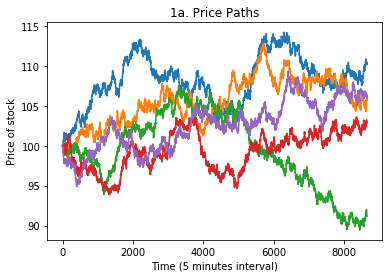

1b. Black-Scholes call option price: 4.614997129602855
1c. Monte-Carlo simulation option price [0.75860417 0.74439422 0.7435846  0.74351983]
    Stderr: [0.11433045 0.11127181 0.10839653 0.10837449]


In [2]:
####################################################################################
######## 1. Black-Scholes: Closed Form Solution vs. Monte-Carlo Simulation #########
####################################################################################
#---------------------part a-----------------------#
def StockPrices(S0, r, sd, delta, T, paths, steps):
    dt = T/steps
    # Generate stochastic process and its antithetic paths
    Z = np.random.normal(0, 1, paths * (steps)).reshape(paths,(steps))
    dWt = np.sqrt(dt) * Z
    # define the initial value of St
    St = np.zeros((paths, steps + 1))
    St[:, 0] = S0
    for i in range (steps):
        St[:, i+1] = St[:, i]*np.exp((r - delta - 1/2*(sd**2))*dt + sd*dWt[:, i])
    return St

S0 = 100; T = 1/4; K = 100; r = 0.05; sigma = 0.2; delta = 0
steps = 8*12*90; paths = 5

Sim5 = StockPrices(S0,r,sigma,delta,T,paths,steps)
plt.figure()
for i in range(5):
    ax = plt.plot(Sim5[i,:])
plt.xlabel("Time (5 minutes interval)")
plt.ylabel("Price of stock")
plt.title("1a. Price Paths")
plt.show()

#---------------------part b-----------------------#
def f_BS(S0,r,sigma,K,T,type):
    d_1=(np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma * np.sqrt(T))
    d_2=d_1-sigma*np.sqrt(T)
    if type=="call":
        option=(S0*si.norm.cdf(d_1,0.0,1.0)-K*np.exp(-r*T)*si.norm.cdf(d_2,0.0,1.0))
    if type=="put":
        option=(K*np.exp(-r*T)*si.norm.cdf(-d_2, 0.0, 1.0)-S0*si.norm.cdf(-d_1,0.0,1.0))
    return option

BS = f_BS(S0,r,sigma,K,T,"call")
print('1b. Black-Scholes call option price:', BS)


#---------------------part c-----------------------#
paths = [100,1000,1000000,10000000]

def LastStockPrices(S0, r, sd, delta, T, paths, steps):
    dt = T/steps
    # define the initial value of St
    #St = np.array([S0]*paths)
    dWt = np.random.normal(0, 1, paths)*np.sqrt(dt)
    ST =  [ S0*np.exp( sd*w + (r - delta - sd*sd/2)*T ) for w in dWt ]

    return ST

Option_value = np.zeros(len(paths))
stderr = np.zeros(len(paths))
for i in range(len(paths)):
    # get stock prices at time T
    p = np.array(LastStockPrices(S0,r,sigma,delta,T,paths[i],steps))

    # Calculate the payoffs -> discount to time 0 -> get the mean of simulations
    payoff = np.maximum(p - K, 0)
    Option_value[i] = np.mean(payoff*np.exp(-r*T))
    stderr[i] = np.std(payoff)

print('1c. Monte-Carlo simulation option price', Option_value)
print('    Stderr:', stderr)



2a. Number of OUT paths: 3 , Put option price: 1.6692658838367616


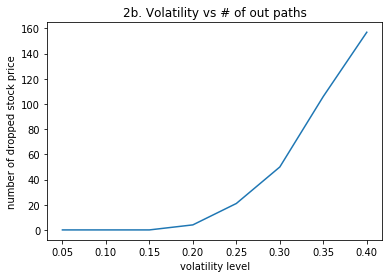

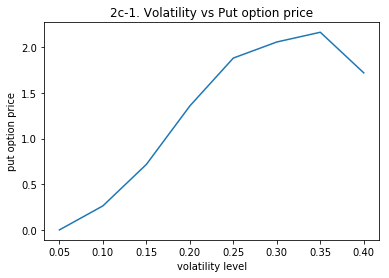

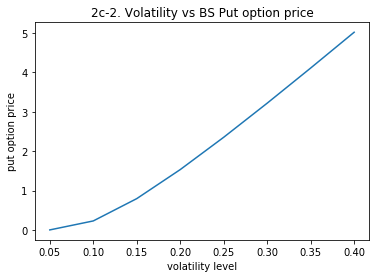

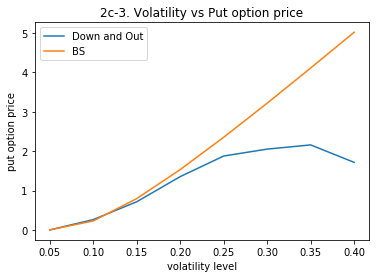

In [3]:
####################################################################################
##########   2. Down-And-Out Put Option Price by Monte-Carlo Simulation   ##########
####################################################################################

S0 = 100; T = 1/4; K = 95; Sb = 75; r = 0.05; sigma = 0.2; delta = 0
steps = 8*12*90; paths = 1000

#---------------------part a-----------------------#
Sim = StockPrices(S0,r,sigma,delta,T,paths,steps)

def find_min(Sim):
    sim = Sim
    count = 0
    for i in range(paths):
        for j in range(steps):
            if sim[i,j] < Sb:
                count += 1
                sim[i,:] = 1000
                break
    return count, sim

count,excludOUT = find_min(Sim)

def down_out_PUT(stock,K,T,r):
    price = stock[:,-1]
    option = np.maximum(K - price,0)
    Option = np.mean(option*np.exp(-r*T))
    return Option

price = down_out_PUT(excludOUT,K,T,r)

print('2a. Number of OUT paths:', count, ', Put option price:', price)

#---------------------part b-----------------------#
sigma = np.arange(0.05,0.45,0.05)
out = []
for i in sigma:
    Sim = StockPrices(S0,r,i,delta,T,paths,steps)
    out = np.append(out,find_min(Sim)[0])

plt.figure()
ax = plt.plot(sigma,out)
plt.xlabel("volatility level")
plt.ylabel("number of dropped stock price")
plt.title("2b. Volatility vs # of out paths")
plt.show()

#---------------------part c-----------------------#
BS = []
put = []
for i in sigma:
    Sim = StockPrices(S0,r,i,delta,T,paths,steps)
    put = np.append(put,down_out_PUT(find_min(Sim)[1],K,T,r))
    BS = np.append(BS,f_BS(S0,r,i,K,T,"put"))

#print('2c. put:\n', put)

plt.figure()
ax = plt.plot(sigma,put)
#plt.errorbar(sigma, put, xerr=0.5, yerr=2*std, linestyle='')
plt.xlabel("volatility level")
plt.ylabel("put option price")
plt.title("2c-1. Volatility vs Put option price")
plt.show()

plt.figure()
ax = plt.plot(sigma,BS)
plt.xlabel("volatility level")
plt.ylabel("put option price")
plt.title("2c-2. Volatility vs BS Put option price")
plt.show()

plt.figure()
ax1 = plt.plot(sigma,put)
ax2 = plt.plot(sigma,BS)
plt.xlabel("volatility level")
plt.ylabel("put option price")
plt.title("2c-3. Volatility vs Put option price")
plt.legend(["Down and Out","BS"])
plt.show()



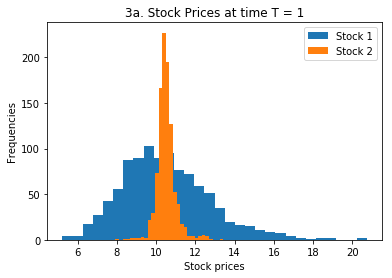

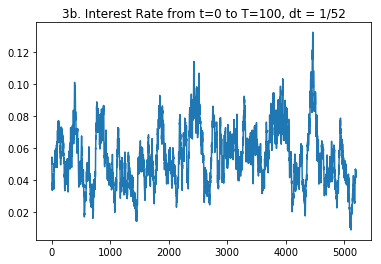

3c. Call option on asset 1 with K = 10 and T = 0.5: 0.7318
3d. Option value: 1.3289


In [4]:
####################################################################################
##########   3. Pricing Exotic Options in Complicated Market Structures   ##########
####################################################################################

def stockPrice(r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N):
    step = int(T/dt)

    # Generate brownian motion paths
    dB_1 = np.sqrt(dt) * np.random.normal(0, 1, N*step).reshape(N, step)
    dB_2 = np.sqrt(dt) * np.random.normal(0, 1, N*step).reshape(N, step)

    # Define interest rate, stock 1, and stock 2 arrays
    rates = np.zeros((N, step+1))
    stock_1 = np.zeros((N, step+1))
    stock_2 = np.zeros((N, step+1))

    # Initialize and generate interest rates paths
    rates[:, 0] = r0
    for i in np.arange(1, step+1, 1):
        rates[:, i] = rates[:, i-1] + alpha*(beta - rates[:, i-1])*dt + delta*np.sqrt(rates[:, i-1])*dB_1[:, i-1]
    
    # Initialize and generate stock price paths
    stock_1[:, 0] = S_10
    stock_2[:, 0] = S_20
    for i in range(1, step+1, 1):
        stock_1[:, i] = stock_1[:, i-1] + rates[:, i-1]*stock_1[:, i-1]*dt + sigma_11*np.sqrt(stock_1[:, i-1])*dB_1[:, i-1] + sigma_12*stock_1[:, i-1]*dB_2[:, i-1]
        stock_2[:, i] = stock_2[:, i-1] + rates[:, i-1]*stock_2[:, i-1]*dt + sigma_21*(stock_1[:, i-1] - stock_2[:, i-1])*dB_1[:, i-1]

    return rates, stock_1, stock_2


def call_option(K, r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N): 
    # Interest rate and stock prices
    rates, stock_1, stock_2 = stockPrice(r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N)

    # Call option value
    option = np.maximum(stock_1[:, -1] - K, 0)
    value = np.mean( np.exp(-r0*T)*option )

    return value


def option(K, r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N): 
    # Interest rate and stock prices
    rates, stock_1, stock_2 = stockPrice(r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N)

    # Get maximum values for each row (each stock)
    max_stock_1 = np.amax(stock_1, axis = 1) 
    max_stock_2 = np.amax(stock_2, axis = 1)

    # Get option payoff and current option price
    option = np.maximum( np.maximum(max_stock_1, max_stock_2) - K, 0 )
    value = np.mean( np.exp(-r0*T)*option )

    return value

# default parameters for Q3
r0 = beta = 0.05; alpha = 0.6; sigma_11 = 0.2; sigma_12 = 0.2; sigma_21 = 0.3
delta = 0.1; S_10 = S_20 = 10

# 3. (a) 
N = 1000; dt = 1/250; T = 1 # N: simulation paths
rates, stock_1, stock_2 = stockPrice(r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N)

plt.hist(stock_1[:, -1], bins = 30, label = 'Stock 1')
plt.hist(stock_2[:, -1], bins = 30, label = 'Stock 2')
plt.xlabel('Stock prices')
plt.ylabel('Frequencies')
plt.legend()
plt.title('3a. Stock Prices at time T = 1')
plt.show()

# 3. (b)
N = 1; dt = 1/52; T = 100
rates = stockPrice(r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N)[0]

plt.plot(rates.T)
plt.title('3b. Interest Rate from t=0 to T=100, dt = 1/52')
plt.show()

# 3. (c)
N = 10000; dt = 1/250; T = 0.5; K = 10
call_option_value = call_option(K, r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N)

print('3c. Call option on asset 1 with K = 10 and T = 0.5:', round(call_option_value, 4))

# 3. (d)
N = 10000; dt = 1/250; T = 0.5; K = 10
q3d = option(K, r0, alpha, beta, delta, S_10, sigma_11, sigma_12, S_20, sigma_21, dt, T, N)

print('3d. Option value:', round(q3d, 4))



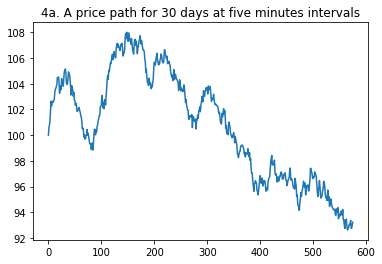

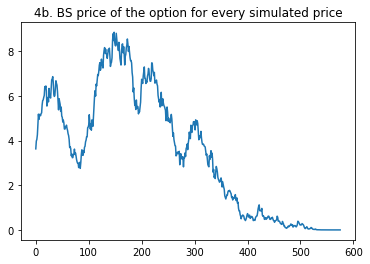

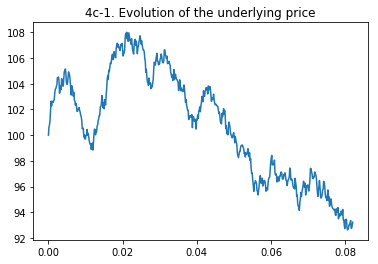

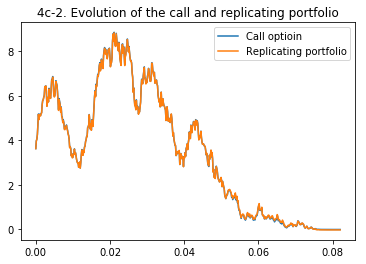

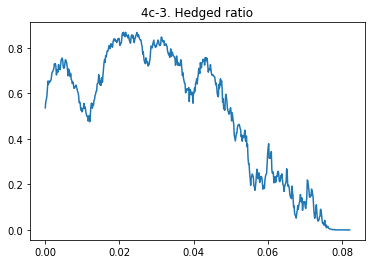

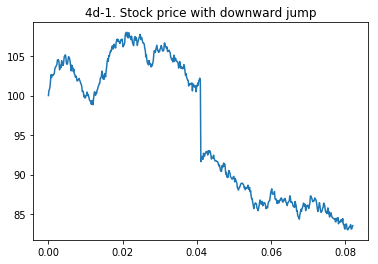

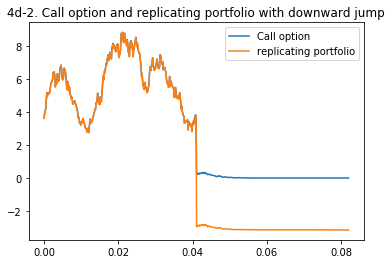

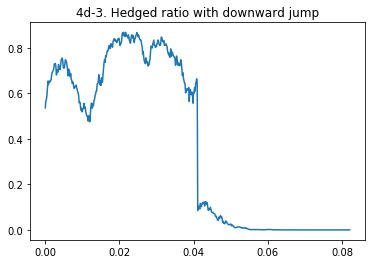

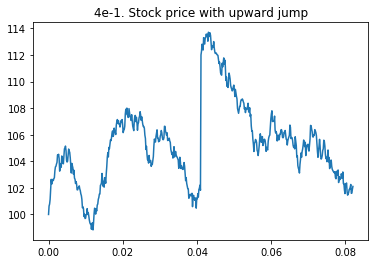

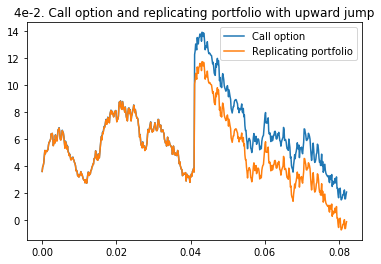

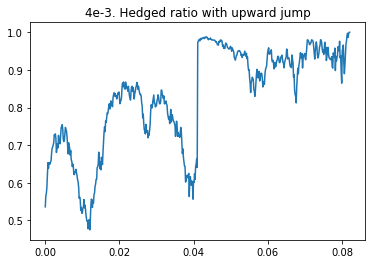

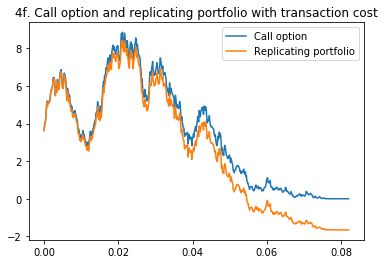

In [5]:
####################################################################################
##########    4. Hedging, Large Price Movements, and Transaction Costs    ##########
####################################################################################

s0 = 100; r = 0.05; sigma = 0.3; mu = 0.2; k = 100; T = 30 / 365; delta = 5 / (365 * 96)

op1 = Option(s0, k, r, sigma, mu, T)

# (a)
path = op1.price_path(delta)
plt.plot(np.arange(len(path)), path)
plt.title('4a. A price path for 30 days at five minutes intervals')
plt.show()

# (b)
step = int(T / delta)
t = np.array([x * delta for x in range(step)])
black_scholes_price = op1.black_scholes(path, t)
plt.plot(np.arange(len(black_scholes_price)), black_scholes_price)
plt.title('4b. BS price of the option for every simulated price')
plt.show()

# (c)
plt.plot(t, path)
plt.title('4c-1. Evolution of the underlying price')
plt.show()

hedged_ratio = op1.delta(path, t)
replica_portfolio = op1.replication_portfolio(path, t, delta)

plt.plot(t, black_scholes_price, label = 'Call optioin')
plt.plot(t, replica_portfolio, label = 'Replicating portfolio')
plt.legend()
plt.title('4c-2. Evolution of the call and replicating portfolio')
plt.show()

plt.plot(t, hedged_ratio)
plt.title('4c-3. Hedged ratio')
plt.show()

# (d)
jump = 0.9
path_with_jump = op1.price_with_jump(delta, jump)
plt.plot(t, path_with_jump)
plt.title('4d-1. Stock price with downward jump')
plt.show()

black_scholes_price_jump = op1.black_scholes(path_with_jump, t)
replica_portfolio_jump = op1.replication_portfolio(path_with_jump, t, delta)
hedged_ratio_jump = op1.delta(path_with_jump, t)
plt.plot(t, black_scholes_price_jump, label = 'Call option')
plt.plot(t, replica_portfolio_jump, label = 'replicating portfolio')
plt.legend()
plt.title('4d-2. Call option and replicating portfolio with downward jump')
plt.show()
plt.plot(t, hedged_ratio_jump)
plt.title('4d-3. Hedged ratio with downward jump')
plt.show()

# (e)
jump = 1.1
path_with_jump2 = op1.price_with_jump(delta, jump)
plt.plot(t, path_with_jump2)
plt.title('4e-1. Stock price with upward jump')
plt.show()
black_scholes_price_jump2 = op1.black_scholes(path_with_jump2, t)
replica_portfolio_jump2 = op1.replication_portfolio(path_with_jump2, t, delta)
hedged_ratio_jump2 = op1.delta(path_with_jump2, t)
plt.plot(t, black_scholes_price_jump2, label = 'Call option')
plt.plot(t, replica_portfolio_jump2, label = 'Replicating portfolio')
plt.legend()
plt.title('4e-2. Call option and replicating portfolio with upward jump')
plt.show()
plt.plot(t, hedged_ratio_jump2)
plt.title('4e-3. Hedged ratio with upward jump')
plt.show()

# (f)
transaction_cost = 0.002
replica_portfolio_transaction = op1.replication_portfolio(path, t, delta, transaction_cost)
plt.plot(t, black_scholes_price, label = 'Call option')
plt.plot(t, replica_portfolio_transaction, label = 'Replicating portfolio')
plt.legend()
plt.title('4f. Call option and replicating portfolio with transaction cost')
plt.show()



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


5a. Black-Scholes price of the option: 2.8028956210785694 
   Heston price of the option: 4.914110947838286


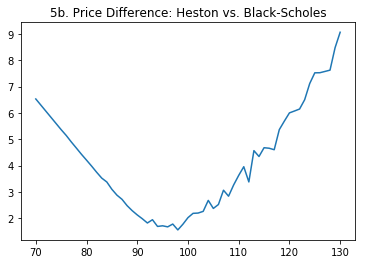

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:85: ComplexWarning: Casting complex values to real discards the imaginary part


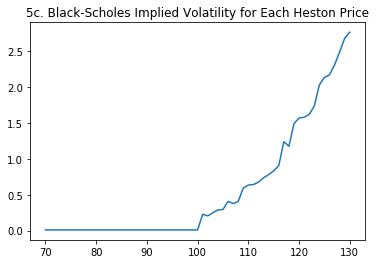

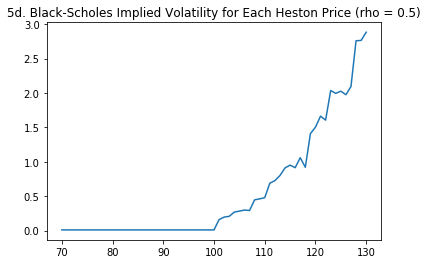

In [6]:
####################################################################################
##########                        5. Heston Model                         ##########
####################################################################################

# Problem 5
K=100; r=0.04; T=0.5; t=0; sigma=0.3; rho=-0.5; k=6; theta=0.02
st=100; xt=np.log(st); lamda=0; tau=T-t; vt=0.01
 
# a. 
# Black Sholes model
def bs_opt(st):
    P,A,B,g,d=np.zeros((2,1)),np.zeros((2,1),dtype=complex),np.zeros((2,1),dtype=complex),np.zeros((2,1),dtype=complex),np.zeros((2,1),dtype=complex)
    b,u,i,phi,Pintegral=np.zeros((2,1)),np.zeros((2,1)),np.zeros((2,1),dtype=complex),np.zeros((2,1)),np.zeros((2,1))
    b[0]=k+lamda-rho*sigma
    b[1]=k+lamda
    u[0],u[1]=0.5,-0.5
    x0=np.log(st)
    dw=1
    for w in range(1,1000):
        for i in range(2):
            d[i]=((rho*sigma*w*1j-b[i])**2-sigma**2*(2*u[i]*w*1j-w**2))**0.5
            g[i]=(b[i]-rho*sigma*w*1j+d[i])/(b[i]-rho*sigma*w*1j-d[i])
            A[i]=r*w*T*1j+k*theta/sigma**2*((b[i]-rho*sigma*w*1j+d[i])*T-2*np.log((1-g[i]*np.exp(d[i]*T))/(1-g[i])))
            B[i]=(b[i]-rho*sigma*w*1j+d[i])/sigma**2*(1-np.exp(d[i]*T))/(1-g[i]*np.exp(d[i]*T))
            phi[i]=np.exp(A[i]+B[i]*vt+w*x0*1j)
            Pintegral[i]=Pintegral[i]+np.real(np.exp(-w*np.log(K)*1j)*phi[i]/(w*1j))*dw
    for i in range(2):
        P[i]=0.5+(1/np.pi)*Pintegral[i]
     
    price=st*P[0]-K*np.exp(-r*T)*P[1]
     
    return price[0]
     
# BS price   
bs=bs_opt(100)
     
# Heston model
def hs_opt(st):
    N=500
    dt=T/N
    sim=1000
    v,s=np.zeros((sim,N+1)),np.zeros((sim,N+1))
    s[:,0]=st
    v[:,0]=vt
    N1=np.random.normal(0,1,(sim,N))
    N2=np.random.normal(0,1,(sim,N))
    N2=N1*rho+N2*(1-rho**2)**0.5
    for i in range(N):
        s[:,i+1]=s[:,i]+s[:,i]*r*dt+s[:,i]*np.sign(v[:,i])*(np.absolute(v[:,i]))**0.5*dt**0.5*N1[:,i]
        v[:,i+1]=v[:,i]+k*(theta-v[:,i])*dt+sigma*np.sign(v[:,i])*(np.absolute(v[:,i]))**0.5*dt**0.5*N2[:,i]
    price=np.mean(np.maximum(s[:,N]-K,0))*np.exp(-T*r)
    return price
 
# Heston price of option
hs=hs_opt(100)
print('5a. Black-Scholes price of the option:', bs, '\n   Heston price of the option:', hs)
 
# b.
stock=range(70,131,1)
difference=np.zeros(len(stock))
 
for i in range(len(stock)):
    st=stock[i]
    difference[i]=hs_opt(st)-bs_opt(st)
 
plt.plot(stock,difference)
plt.title('5b. Price Difference: Heston vs. Black-Scholes')
plt.show()
     
# c.
def bs_opt2(st,vt):
    P,A,B,g,d=np.zeros((2,1)),np.zeros((2,1),dtype=complex),np.zeros((2,1),dtype=complex),np.zeros((2,1),dtype=complex),np.zeros((2,1),dtype=complex)
    b,u,i,phi,Pintegral=np.zeros((2,1)),np.zeros((2,1)),np.zeros((2,1),dtype=complex),np.zeros((2,1)),np.zeros((2,1))
    b[0]=k+lamda-rho*sigma
    b[1]=k+lamda
    u[0],u[1]=0.5,-0.5
    x0=np.log(st)
    dw=1
    for w in range(1,1000):
        for i in range(2):
            d[i]=((rho*sigma*w*1j-b[i])**2-sigma**2*(2*u[i]*w*1j-w**2))**0.5
            g[i]=(b[i]-rho*sigma*w*1j+d[i])/(b[i]-rho*sigma*w*1j-d[i])
            A[i]=r*w*T*1j+k*theta/sigma**2*((b[i]-rho*sigma*w*1j+d[i])*T-2*np.log((1-g[i]*np.exp(d[i]*T))/(1-g[i])))
            B[i]=(b[i]-rho*sigma*w*1j+d[i])/sigma**2*(1-np.exp(d[i]*T))/(1-g[i]*np.exp(d[i]*T))
            phi[i]=np.exp(A[i]+B[i]*vt+w*x0*1j)
            Pintegral[i]=Pintegral[i]+np.real(np.exp(-w*np.log(K)*1j)*phi[i]/(w*1j))*dw
    for i in range(2):
        P[i]=0.5+(1/np.pi)*Pintegral[i]
     
    price=st*P[0]-K*np.exp(-r*T)*P[1]
     
    return price[0]
 
def vol(st):
    # Heston price of option
    hs=hs_opt(st)
         
    v=np.zeros(100)
    v[0]=vt
    if st <=100:
        for i in range(1,100):
            # compute vega
            d1=(np.log(st/K)+(r+v[i-1]**2/2)*T)/(v[i-1]*np.sqrt(T))
            vega=st*si.norm(0,1).cdf(d1)*np.sqrt(T)
            if (bs_opt2(st,v[i-1])-hs) < 0.1:
                return v[i-1]
            else:
                v[i]=v[i-1]-(bs_opt2(st,v[i-1])-hs)/float(vega)
    else:
        for i in range(1,100):
            # compute vega
            d1=(np.log(st/K)+(r+v[i-1]**2/2)*T)/(v[i-1]*np.sqrt(T))
            vega=st*si.norm(0,1).cdf(d1)*np.sqrt(T)
            v[i]=v[i-1]-(bs_opt2(st,v[i-1])-hs)/float(vega)
                 
    return v[99]
 
stock=range(70,131,1)
imp_vol=np.zeros(len(stock))
 
for i in range(len(stock)):
    st=stock[i]
    imp_vol[i]=vol(st)
 
plt.plot(stock,imp_vol)
plt.title('5c. Black-Scholes Implied Volatility for Each Heston Price')
plt.show()
 
# d.
rho=0.5
 
stock=range(70,131,1)
imp_vol2=np.zeros(len(stock))
 
for i in range(len(stock)):
    st=stock[i]
    imp_vol2[i]=vol(st)
 
plt.plot(stock,imp_vol2)
plt.title('5d. Black-Scholes Implied Volatility for Each Heston Price (rho = 0.5)')
plt.show()